In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import os
import sys
import logging
import torch
import socket
from peaknet.datasets.panels_v2  import ConfigDataset, SFXPanelDatasetMini
from peaknet.methods.unet        import UNet
from peaknet.model               import ConfigPeakFinderModel, PeakFinderModel
from peaknet.trainer             import ConfigTrainer, Trainer
from peaknet.validator           import ConfigValidator, LossValidator
from peaknet.utils               import init_logger, EpochManager, MetaLog

timestamp_prev = None
## timestamp_prev = "2022_1024_1115_01"

# Set up parameters for an experiment...
fl_csv                = 'datasets.csv'
drc_project           = os.getcwd()
size_sample_train     = 20
size_sample_validate  = 20
frac_train            = 0.5
base_channels         = 8
frac_validate         = None
dataset_usage         = 'train'
## init_std              = 2 * 1e-3

pos_weight = 2.0

size_batch = 20
lr         = 5*1e-3
## lr         = 4*1e-9
seed       = 0

# Clarify the purpose of this experiment...
hostname = socket.gethostname()
comments = f"""
            Hostname: {hostname}.

            Online training.

            Fraction    (train)     : {frac_train}
            Sample size (train)     : {size_sample_train}
            Sample size (validate)  : {size_sample_validate}
            Batch  size             : {size_batch}
            lr                      : {lr}
            pos_weight              : {pos_weight}
            base_channels           : {base_channels}
            continued training???   : from {timestamp_prev}

            """

# [[[ LOGGING ]]]
timestamp = init_logger(returns_timestamp = True)

# Create a metalog to the log file, explaining the purpose of this run...
metalog = MetaLog( comments = comments )
metalog.report()

# [[[ DATASET ]]]
# Config the dataset...
config_dataset = ConfigDataset( fl_csv         = fl_csv,
                                drc_project    = drc_project,
                                size_sample    = size_sample_train,
                                dataset_usage  = dataset_usage,
                                trans          = None,
                                frac_train     = frac_train,
                                frac_validate  = frac_validate,
                                mpi_comm       = None,
                                seed           = seed,
                                mask_radius    = 3,
                                snr_threshold  = 0.3,
                                adu_threshold  = 1000 )

# Define the training set
dataset_train = SFXPanelDatasetMini(config_dataset)
dataset_train.cache_img()

# Define validation set...
config_dataset.size_sample   = size_sample_validate
config_dataset.dataset_usage = 'validate'

dataset_validate = SFXPanelDatasetMini(config_dataset)
dataset_validate.cache_img()


# [[[ IMAGE ENCODER ]]]
# Config the encoder...
method = UNet(base_channels = base_channels, 
              in_channels = 1, 
              out_channels = 1,)


# [[[ MODEL ]]]
# Config the model...
config_peakfinder = ConfigPeakFinderModel( method     = method,
                                           pos_weight = pos_weight, )
model = PeakFinderModel(config_peakfinder)
model.init_params(from_timestamp = timestamp_prev)


# [[[ TRAINER ]]]
# Config the trainer...
config_train = ConfigTrainer( num_workers    = 1,
                              batch_size     = size_batch,
                              pin_memory     = True,
                              shuffle        = False,
                              lr             = lr, )

# Training...
trainer = Trainer(model, dataset_train, config_train)


# [[[ VALIDATOR ]]]
config_validator = ConfigValidator( num_workers    = 1,
                                    batch_size     = size_batch,
                                    pin_memory     = True,
                                    shuffle        = False,
                                    lr             = lr, )
validator = LossValidator(model, dataset_validate, config_validator)


# # [[[ EPOCH MANAGER ]]]
# max_epochs = 5
# epoch_manager = EpochManager( trainer    = trainer, 
#                               validator  = validator, 
#                               max_epochs = max_epochs, 
#                               timestamp  = timestamp, )
# epoch_manager.run()

In [46]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Run epochs

In [99]:
param_update_history_dict = {}

In [102]:
max_epochs = 50
for epoch in range(max_epochs):
    loss = trainer.train(epoch = epoch, returns_loss = True)
    print(f"loss = {loss:.8f}")
    
    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.grad is None: continue
            
            if name not in param_update_history_dict: param_update_history_dict[name] = []
            
            # Calculate update_ratio at each layer...
            update_ratio = ((lr*param.grad).std() / param.std()).log10().item()
            
            param_update_history_dict[name].append(update_ratio)

100%|██████████| 1/1 [00:00<00:00,  5.41it/s]

loss = 0.03942552



100%|██████████| 1/1 [00:00<00:00,  6.48it/s]

loss = 0.04271253



100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

loss = 0.02587061



100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

loss = 0.02183537



100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

loss = 0.02527642



100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

loss = 0.05021441



100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

loss = 0.01068398



100%|██████████| 1/1 [00:00<00:00,  6.60it/s]

loss = 0.03433143



100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

loss = 0.01882435



100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

loss = 0.04822093



100%|██████████| 1/1 [00:00<00:00,  7.31it/s]

loss = 0.01276205



100%|██████████| 1/1 [00:00<00:00,  6.71it/s]

loss = 0.00448254



100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

loss = 0.00923739



100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

loss = 0.41359404



100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

loss = 0.00459191



100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

loss = 0.10764220



100%|██████████| 1/1 [00:00<00:00,  6.56it/s]

loss = 0.00417944



100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

loss = 0.03826197



100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

loss = 0.01353208



100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

loss = 0.11586926



100%|██████████| 1/1 [00:00<00:00,  6.55it/s]

loss = 0.00351014



100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

loss = 0.24428754



100%|██████████| 1/1 [00:00<00:00,  6.49it/s]

loss = 0.00292670



100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

loss = 0.12404359



100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

loss = 0.00409966



100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

loss = 0.00383466



100%|██████████| 1/1 [00:00<00:00,  7.11it/s]

loss = 0.02268451



100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

loss = 0.03006355



100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

loss = 0.00919561



100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

loss = 0.10946833



100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

loss = 0.00493278



100%|██████████| 1/1 [00:00<00:00,  6.46it/s]

loss = 0.00323524



100%|██████████| 1/1 [00:00<00:00,  6.52it/s]

loss = 0.18189141



100%|██████████| 1/1 [00:00<00:00,  6.53it/s]

loss = 0.00547812



100%|██████████| 1/1 [00:00<00:00,  6.62it/s]

loss = 0.01284230



100%|██████████| 1/1 [00:00<00:00,  6.76it/s]

loss = 0.05159543



100%|██████████| 1/1 [00:00<00:00,  6.66it/s]

loss = 0.00480295



100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

loss = 0.00203145



100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

loss = 0.03503083



100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

loss = 0.01088417



100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

loss = 0.06486406



100%|██████████| 1/1 [00:00<00:00,  6.83it/s]

loss = 0.00529669



100%|██████████| 1/1 [00:00<00:00,  6.45it/s]

loss = 0.00215591



100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

loss = 0.00321600



100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

loss = 0.00442083



100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

loss = 0.24689263



100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

loss = 0.00186714



100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

loss = 0.04893473



100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

loss = 0.00349985



100%|██████████| 1/1 [00:00<00:00,  7.29it/s]

loss = 0.05176521


## Global hook

In [15]:
activation_dict = {}
preactivation_dict = {}
def get_activation(name, tag = ''):
    if tag not in preactivation_dict: preactivation_dict[tag] = {}
    if tag not in activation_dict: activation_dict[tag] = {}
    def hook(model, input, output):
        preactivation_dict[tag][name] = input
        activation_dict[tag][name] = output
    return hook

In [16]:
for name, layer in model.named_modules(): 
    if isinstance(layer, torch.nn.ReLU):
        layer.register_forward_hook(get_activation(name, 'relu'))

    if "final_conv" in name:
        layer.register_forward_hook(get_activation(name, 'final_conv'))

## Debug by checking feature maps

In [84]:
activation_dict['relu'].keys()

dict_keys(['method.down_conv.0.act1', 'method.down_conv.0.act2', 'method.down_conv.1.act1', 'method.down_conv.1.act2', 'method.down_conv.2.act1', 'method.down_conv.2.act2', 'method.down_conv.3.act1', 'method.down_conv.3.act2', 'method.middle_conv.act1', 'method.middle_conv.act2', 'method.up_conv.0.act1', 'method.up_conv.0.act2', 'method.up_conv.1.act1', 'method.up_conv.1.act2', 'method.up_conv.2.act1', 'method.up_conv.2.act2', 'method.up_conv.3.act1', 'method.up_conv.3.act2'])

In [ ]:
preamap = preactivation_dict['final_conv']['method.final_conv']
preamap
print(preamap[0].data.shape)
data = preamap[0].cpu().detach().numpy()
## data = amap.sigmoid().cpu().detach().numpy()
## data[data < 1-1e-2] = 0

ncols = 4
nrows = 5

for channel in range(data.shape[1]):
    fig   = plt.figure(figsize = (14, 15))
    gspec = fig.add_gridspec( nrows, ncols,
                              #width_ratios  = [1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/20],
                              #height_ratios = [1/2, 1/2], 
                            )
    ax_list = [ fig.add_subplot(gspec[j, i], aspect = 1) for i in range(ncols) for j in range(nrows)]
    for i, ax in enumerate(ax_list):
        img = data[i,channel,]
        factor = 1
        vmin = img.mean()
        vmax = vmin + factor * img.std()
        im = ax.imshow(img, vmin = vmin, vmax = vmax)
        #im = ax.imshow(img, vmin = 0, vmax = 1)
        im.set_clim(vmin, vmax)
        ## print(vmin, vmax)
        #im.set_clim(0, 1)
    fig.suptitle(f"Feature map -- {channel:02d}")

torch.Size([20, 1, 176, 192])


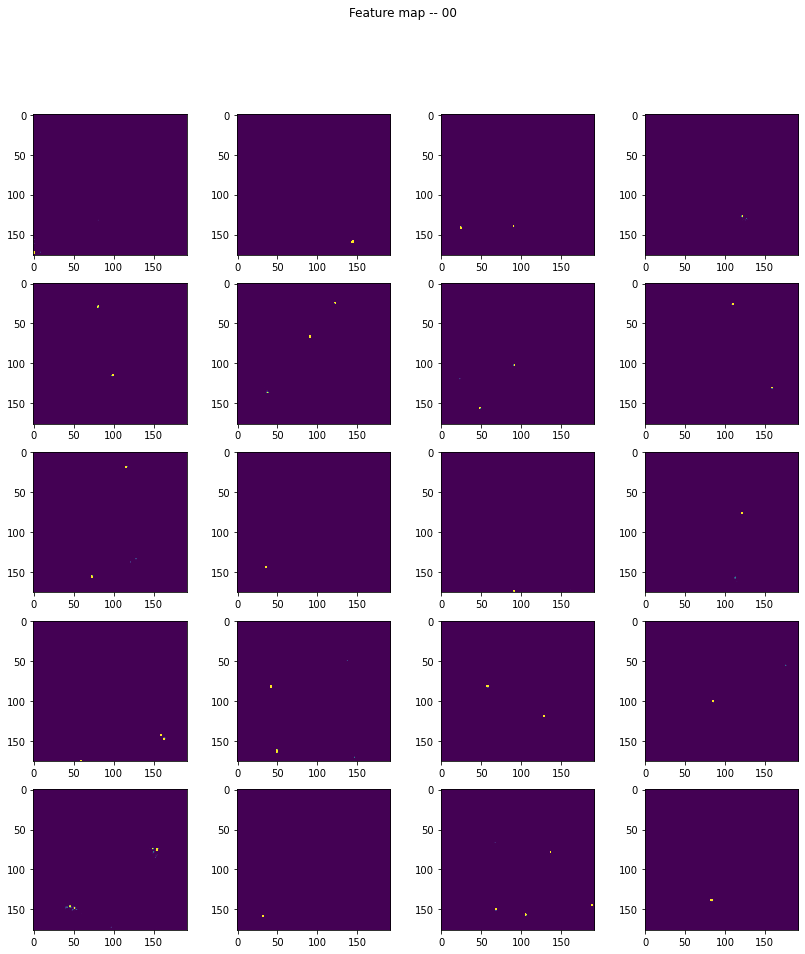

In [108]:
amap = activation_dict['final_conv']['method.final_conv']
amap
print(amap.shape)
##data = amap.cpu().detach().numpy()
data = amap.sigmoid().cpu().detach().numpy()
##data[data < 1-1e-1] = 0

ncols = 4
nrows = 5

for channel in range(data.shape[1]):
    fig   = plt.figure(figsize = (14, 15))
    gspec = fig.add_gridspec( nrows, ncols,
                              #width_ratios  = [1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/20],
                              #height_ratios = [1/2, 1/2], 
                            )
    ax_list = [ fig.add_subplot(gspec[j, i], aspect = 1) for i in range(ncols) for j in range(nrows)]
    for i, ax in enumerate(ax_list):
        img = data[i,channel,]
        factor = 1
        vmin = img.mean()
        vmax = vmin + factor * img.std()
        im = ax.imshow(img, vmin = vmin, vmax = vmax)
        #im = ax.imshow(img, vmin = 0, vmax = 1)
        im.set_clim(vmin, vmax)
        ## print(vmin, vmax)
        #im.set_clim(0, 1)
    fig.suptitle(f"Feature map -- {channel:02d}")

## Debug by checking weights and gradients

In [36]:
for name, param in model.named_parameters(): print(name)

method.down_conv.0.first.weight
method.down_conv.0.first.bias
method.down_conv.0.batch_norm1.weight
method.down_conv.0.batch_norm1.bias
method.down_conv.0.second.weight
method.down_conv.0.second.bias
method.down_conv.0.batch_norm2.weight
method.down_conv.0.batch_norm2.bias
method.down_conv.1.first.weight
method.down_conv.1.first.bias
method.down_conv.1.batch_norm1.weight
method.down_conv.1.batch_norm1.bias
method.down_conv.1.second.weight
method.down_conv.1.second.bias
method.down_conv.1.batch_norm2.weight
method.down_conv.1.batch_norm2.bias
method.down_conv.2.first.weight
method.down_conv.2.first.bias
method.down_conv.2.batch_norm1.weight
method.down_conv.2.batch_norm1.bias
method.down_conv.2.second.weight
method.down_conv.2.second.bias
method.down_conv.2.batch_norm2.weight
method.down_conv.2.batch_norm2.bias
method.down_conv.3.first.weight
method.down_conv.3.first.bias
method.down_conv.3.batch_norm1.weight
method.down_conv.3.batch_norm1.bias
method.down_conv.3.second.weight
method.do

layer 00 (      down_conv.0.first.weight): mean +2.978413e-02, std 4.756617e-01
layer 04 (     down_conv.0.second.weight): mean -1.664567e-03, std 1.708923e-01
layer 08 (      down_conv.1.first.weight): mean -8.724079e-04, std 1.806360e-01
layer 12 (     down_conv.1.second.weight): mean -1.320632e-02, std 1.360279e-01
layer 16 (      down_conv.2.first.weight): mean -6.745122e-03, std 1.321016e-01
layer 20 (     down_conv.2.second.weight): mean -9.644764e-03, std 1.016521e-01
layer 24 (      down_conv.3.first.weight): mean -5.432010e-03, std 9.752507e-02
layer 28 (     down_conv.3.second.weight): mean -1.105606e-02, std 7.273076e-02
layer 32 (      middle_conv.first.weight): mean -9.895220e-03, std 6.984656e-02
layer 36 (     middle_conv.second.weight): mean -2.160314e-03, std 5.744372e-02
layer 40 (         up_sample.0.up.weight): mean -7.405485e-04, std 6.914607e-02
layer 42 (         up_sample.1.up.weight): mean +1.105274e-03, std 8.589264e-02
layer 44 (         up_sample.2.up.weight

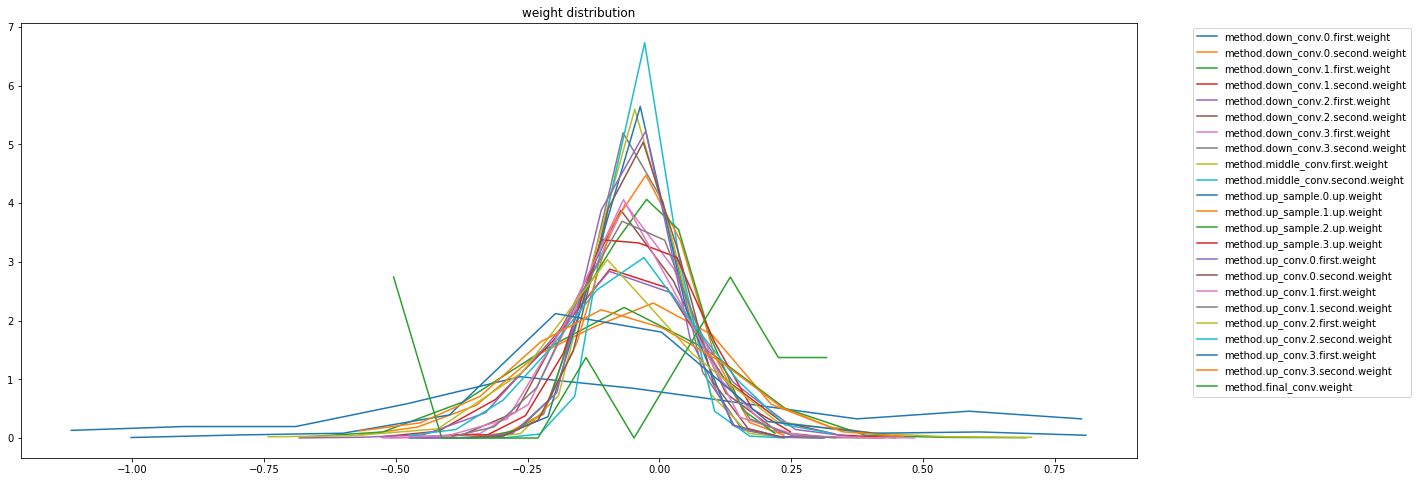

In [105]:
plt.figure( figsize = (20, 8) )
for i, (name, param) in enumerate(model.named_parameters()):
    if param.grad is None: continue
    
    # Skip biases...
    if "bias" in name: continue
    
    print('layer %02d (%30s): mean %+e, std %e' % (i, name[name.find(".")+1:], param.data.mean(), param.data.std()))
    
    hy, hx = np.histogram(param.data.cpu().detach().numpy(), density = True)
    plt.plot(hx[:-1], hy, label = name)
plt.legend(bbox_to_anchor=(1.25, 1.00));
plt.title('weight distribution');

layer 00 (      down_conv.0.first.weight): mean +1.310694e-03, std 6.750550e-03
layer 04 (     down_conv.0.second.weight): mean +2.854629e-04, std 6.980317e-03
layer 08 (      down_conv.1.first.weight): mean +2.613115e-03, std 9.352487e-03
layer 12 (     down_conv.1.second.weight): mean +1.857588e-03, std 5.748272e-03
layer 16 (      down_conv.2.first.weight): mean +5.731689e-04, std 1.859273e-03
layer 20 (     down_conv.2.second.weight): mean +1.788678e-04, std 8.974245e-04
layer 24 (      down_conv.3.first.weight): mean +1.273598e-04, std 5.731574e-04
layer 28 (     down_conv.3.second.weight): mean +6.323258e-05, std 3.828898e-04
layer 32 (      middle_conv.first.weight): mean +8.502505e-05, std 3.663172e-04
layer 36 (     middle_conv.second.weight): mean +2.793704e-05, std 1.745953e-04
layer 40 (         up_sample.0.up.weight): mean +6.686594e-06, std 2.359698e-04
layer 42 (         up_sample.1.up.weight): mean +2.142958e-05, std 6.816005e-04
layer 44 (         up_sample.2.up.weight

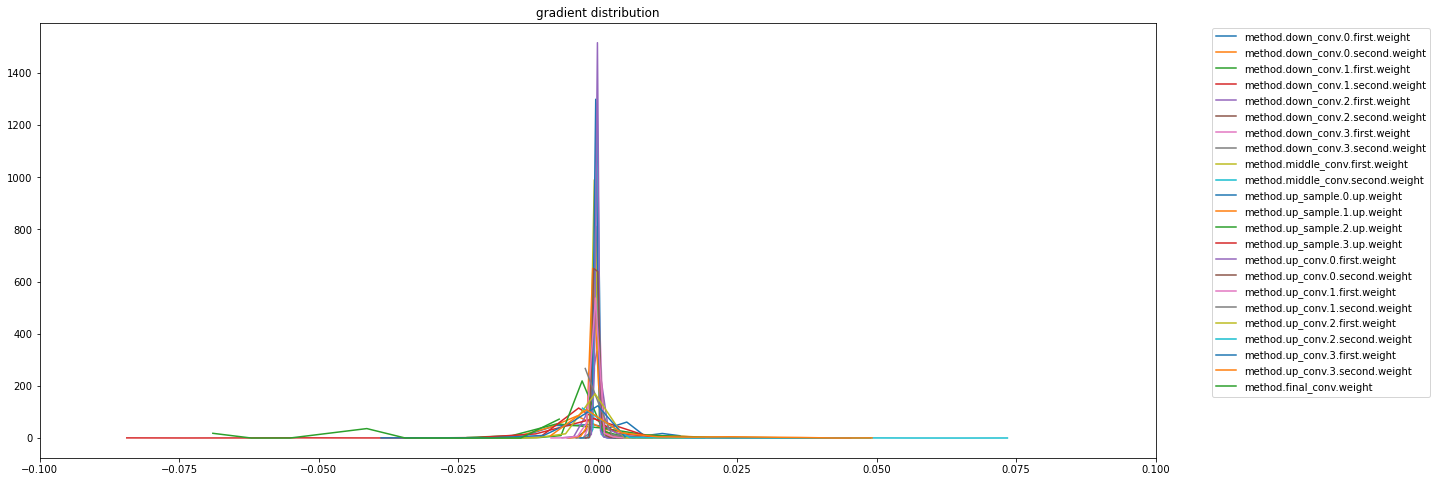

In [106]:
plt.figure( figsize = (20, 8) )
for i, (name, param) in enumerate(model.named_parameters()):
    # Skip biases...
    if "bias" in name: continue
    
    if param.grad is None: continue
    
    print('layer %02d (%30s): mean %+e, std %e' % (i, name[name.find(".")+1:], param.grad.mean(), param.grad.std()))
    
    hy, hx = np.histogram(param.grad.cpu().detach().numpy(), density = True)
    plt.plot(hx[:-1], hy, label = name)
plt.xlim(-1e-1,1e-1)
plt.legend(bbox_to_anchor=(1.25, 1.00));
plt.title('gradient distribution');

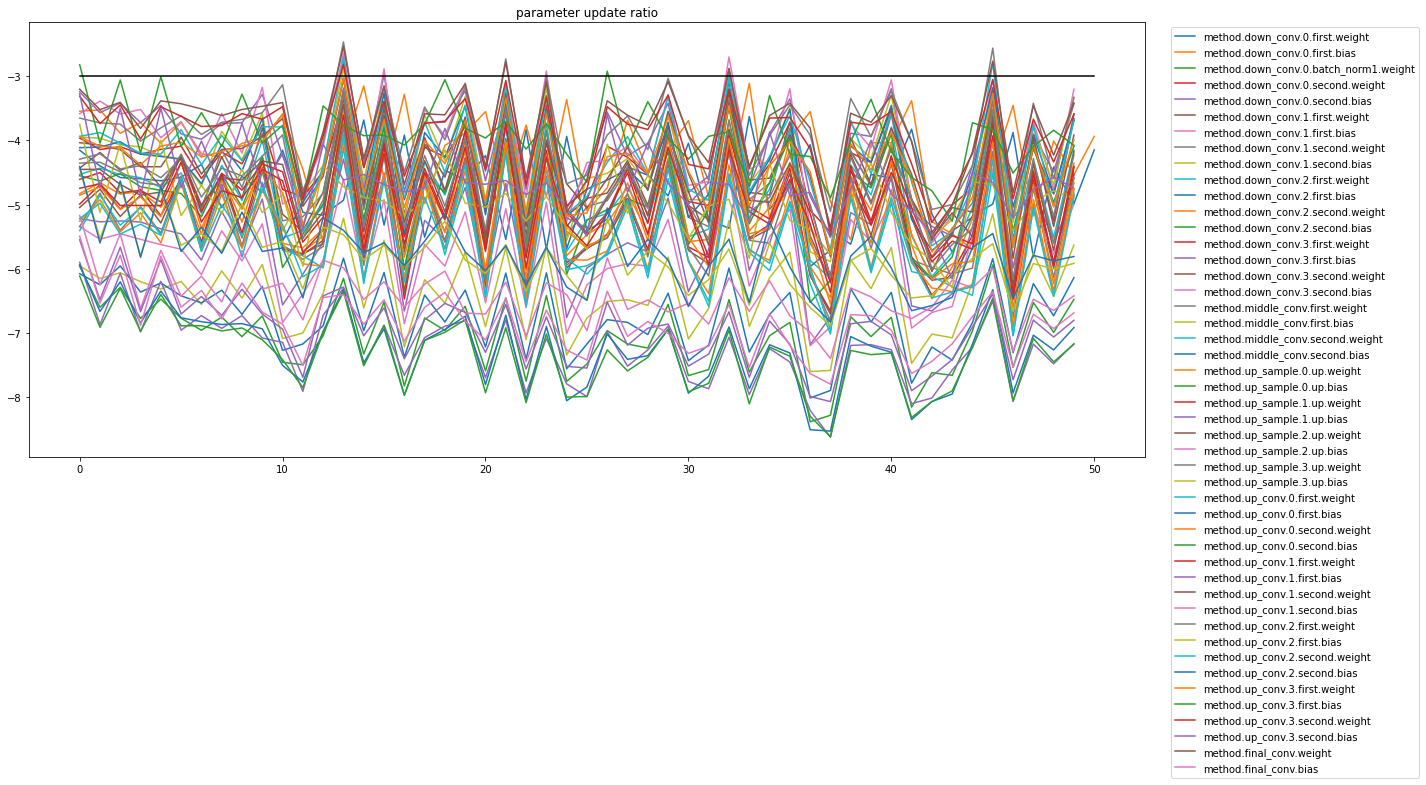

In [104]:
plt.figure(figsize=(20, 8))
for name, param_update_ratio in param_update_history_dict.items():
    plt.plot(param_update_ratio, label = name)
plt.plot([0, len(param_update_list)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(bbox_to_anchor=(1.25, 1.00));
plt.title('parameter update ratio');